# Burn scar mapping on Sentinel 2 Near Real Time data

* __Compatability:__ Notebook currently only compatible with DEA Sandbox environment as near real time data is not avaible on the NCI
* **Products used:** 
[s2a_nrt_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_nrt_granule), 
[s2b_nrt_granule](https://explorer.sandbox.dea.ga.gov.au/s2b_nrt_granule),
[s2a_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_ard_granule), 
[s2b_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2b_ard_granule),

## Background



This notebook calculates the change in Normalised Burn Ratio between a baseline composite image of the pre-fire condition and a post-fire event image, in order to find burn scar extent. 
 
The user can change the location over which this notebook is run and specify a different date between which pre and post fire condition will be compared. The length of time over which the baseline composite image will be generated can be specified as 3, 6 or 12 months. The code in this notebook will automatically generate the composite image over the set length of time using both Sentinel 2 Near Real Time data and the definitive Sentinel 2 Analysis Ready Product. 

For the post-fire event observation the notebook will look for the first observation after the given fire event date that is relatively cloud free. 

### Normalised Burn Ratio

The Normalised Burn Ratio (NBR) is an index that uses the differences in the way health green vegetation and burnt vegetation reflect light to find burnt area. It is calculated using the following Sentinel 2 bands; Near Infrared/Band 8 and Shortwave Infrared/Band 12. The equation is defined below: 

\begin{equation}
NBR = \frac{(NIR - SWIR)}{(NIR + SWIR)}
\end{equation}

NBR returns values between -1 and 1. __Healthy green vegetation will have a high NBR value while burned vegetation will have a low value__. Areas of dry brown vegetation or bare soil will also return lower NBR values than green vegetation. 

### Delta Normalised Burn Ratio

Change in Normalised Burn Ration, also called Delta Normalised Burn Ration (dNBR) is calculated by subtracting the post fire NBR value from the baseline NBR value as defined in this equation:

\begin{equation}
dNBR = NBR_{baseline} - NBR_{post fire}
\end{equation}

The dNBR value can be more useful than the NBR alone to determine what has burnt as it shows change from the baseline sate. __A burnt area will have a positive dNBR value__ while an unburnt area will have a negative dNBR value or a value close to zero.

dNBR can also be used to describe burn severity (although this notebook does not look at burn severity) the principal of this is that a higher severity fire will burn more vegetation, resulting in a higher dNBR. More information on NBR, dNBR and using it to measure burn severity can be found [on the UN-SPIDER knowlage portal](http://un-spider.org/advisory-support/recommended-practices/recommended-practice-burn-severity/in-detail/normalized-burn-ratio).

#### Defining Burnt From Unburnt Areas

[Rahman et al. 2018](https://doi.org/10.1109/IGARSS.2018.8518449) found a dNBR threshold value of +0.1 appropreate for differentiating burned from un burned areas when using Sentinel 2. However, some exploration with different threshold levels may be needed to get a good result in areas with different vegetation types. 

In the example presented in this notebook, which covers part of the Clyde Mountain fire in the area north of Batemans Bay the fire occured in heavily forested area, which returns a very storng dNBR result. Using +0.1 as a threshold here results in a lot of false positives being picked un in the unburnt urban and forest areas where vegitation drying has occured prior to the fire. A much more conservative threshold here of +0.3 produces a better result. Keep in mind the limitations of remote sensing and that in an ideal situation ground truth data collected in the location of interest would be used to assist in selecting a threshold.

Some care should also be taken when interoperating results as a number of possible false positives can return a positive dNBR result:
* A lot of smoke in the post burn image can interfere with the dNBR value
* Areas that have been cleared of vegetation by some other means (logging, harvesting, and landslides) towards the end of the baseline period may incorrectly show up as burnt
* Drying out bright green vegetation such as grasses. If a fire event has been preceded by a rapid drying out of vegetation this can result in a low positive dNBR value in areas that have not burnt.


## Load packages
Import Python packages that are used for the analysis.

In [1]:
import sys
import datacube
from datacube.helpers import write_geotiff
from datetime import datetime
from datetime import timedelta
import pandas as pd
import xarray as xr
import numpy as np

#from datacube_stats.statistics import GeoMedian

sys.path.append("../Scripts")
from dea_datahandling import load_ard
from dea_plotting import rgb
from dea_plotting import display_map

In [2]:
dc = datacube.Datacube(app="Sentinel_2_burn_ratio")

## Select Location

The selected latitude and longitude will be displayed as a red box on the map below the next cell. This map can be used to find coordinates of other places, simply scroll and click on any point on the map to display the latitude and longitude of that location.

In [3]:
#location


#Clyde Mountain Fire, Pebbly Beach to North Batemans Bay
lon=(150.1632, 150.3520)
lat=(-35.5886, -35.7345)

#display area on map
display_map(x=lon, y=lat)

## define fire event date and length of composite image

Delta Normalised Burn Ratio produces the best result when using a post-fire image that was collected before much re-growth has occured. However images collected while the fire is still active can be obsured by smoke and not show the full burn extent. As a result some adjustment of the fire event date entered may be needed to get the best restult.

In [4]:
#Fire event date
fire_date = '2020-01-05'

#length of Baseline Period

baseline_length = '12 months' # Can be 3, 6 or 12 months



### Automaticaly define date range for baseline composite image

In [5]:
#define load for geomedian

if baseline_length == '12 months':
    time_step = timedelta(days=365)
if baseline_length == '6 months':
    time_step = timedelta(days=182.5)
if baseline_length == '3 months':
    time_step = timedelta(days=91)

#calculate the start and end date for baseline data load
start_date = datetime.strftime(((datetime.strptime(fire_date, '%Y-%m-%d'))-time_step), '%Y-%m-%d')
end_date = datetime.strftime(((datetime.strptime(fire_date, '%Y-%m-%d'))-timedelta(days=1)), '%Y-%m-%d')

#calculate end date for post fire data load
change_date_end = datetime.strftime(((datetime.strptime(fire_date, '%Y-%m-%d'))+timedelta(days=15)), '%Y-%m-%d')

In [6]:
#print baseline start date
start_date

'2019-01-05'

### load baseline period data from Near Real Time Data

In [7]:
#Load all data in basline period avalible from Near Real Time data

NRT_baseline_da = load_ard(dc=dc,
              products=['s2a_nrt_granule', 's2b_nrt_granule'],#,'s2a_ard_granule', 's2b_ard_granule'],
              x=lon,
              y=lat,
              time=(start_date, end_date),
              measurements=['nbart_blue','nbart_green','nbart_red','nbart_nir_1', 'nbart_swir_3'],
              min_gooddata=0.5,
              output_crs='EPSG:3577',
              resolution=(-10, 10),
              dask_chunks = {'x': 500, 'y': 500},
              group_by='solar_day')

Loading s2a_nrt_granule data
    Filtering to 4 out of 8 observations
    Applying pixel quality mask
Loading s2b_nrt_granule data
    Filtering to 3 out of 6 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 7 observations 


In [8]:
#find the earliest date from which an observation has been returned fron near real time data
first_NRT_date = (pd.to_datetime((NRT_baseline_da.time[0]).values)).strftime('%Y-%m-%d')

In [9]:
first_NRT_date

'2019-10-22'

### Load any remaining baseline period data from Analysis Ready Data

In [10]:

#Load remaining data in basline period avalible from Analysis Ready Data collection (definative sentinel collection)
ARD_baseline_da = load_ard(dc=dc,
              products=['s2a_ard_granule', 's2b_ard_granule'],
              x=lon,
              y=lat,
              time=(start_date, first_NRT_date),
              measurements=['nbart_blue','nbart_green','nbart_red','nbart_nir_1', 'nbart_swir_3'],
              min_gooddata=0.5,
              output_crs='EPSG:3577',
              resolution=(-10, 10),
              dask_chunks = {'x': 500, 'y': 500},
              group_by='solar_day')


Loading s2a_ard_granule data
    Filtering to 14 out of 27 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 17 out of 27 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 31 observations 


### Join all baseline data into one dataset

Data loaded fron Near Real Time product and Analysis Ready Data will be joined into one dataste in order to generate composite image

In [11]:
#Concatinate NRT and ARD data together 

combined_basline = xr.concat([ARD_baseline_da,NRT_baseline_da], dim='time').sortby('time')

combined_basline

<xarray.Dataset>
Dimensions:       (time: 38, x: 1922, y: 1848)
Coordinates:
  * y             (y) float64 -4.004e+06 -4.004e+06 ... -4.023e+06 -4.023e+06
  * x             (x) float64 1.636e+06 1.636e+06 ... 1.656e+06 1.656e+06
  * time          (time) datetime64[ns] 2019-01-15T00:02:41.024000 ... 2019-12-26T00:06:35.965790
Data variables:
    nbart_blue    (time, y, x) float32 312.0 332.0 278.0 264.0 ... nan nan nan
    nbart_green   (time, y, x) float32 409.0 418.0 363.0 331.0 ... nan nan nan
    nbart_red     (time, y, x) float32 342.0 411.0 309.0 292.0 ... nan nan nan
    nbart_nir_1   (time, y, x) float32 2498.0 2456.0 2250.0 ... nan nan nan
    nbart_swir_3  (time, y, x) float32 522.0 522.0 521.0 521.0 ... nan nan nan
Attributes:
    crs:      EPSG:3577

### Generate composite image from baseline data

In [12]:

# Compute geomedian using all observations in the dataset
regmedian = combined_basline.median(dim='time')
regmedian 

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


<xarray.Dataset>
Dimensions:       (x: 1922, y: 1848)
Coordinates:
  * y             (y) float64 -4.004e+06 -4.004e+06 ... -4.023e+06 -4.023e+06
  * x             (x) float64 1.636e+06 1.636e+06 ... 1.656e+06 1.656e+06
Data variables:
    nbart_blue    (y, x) float32 219.0 226.0 218.0 199.0 ... 291.0 284.0 298.0
    nbart_green   (y, x) float32 307.0 312.0 297.0 272.0 ... 168.5 176.5 173.0
    nbart_red     (y, x) float32 244.0 276.0 249.0 225.0 ... 108.5 118.0 118.0
    nbart_nir_1   (y, x) float32 2411.0 2459.0 2308.0 2084.0 ... 80.5 86.0 87.0
    nbart_swir_3  (y, x) float32 363.0 367.0 371.0 371.0 ... 51.0 50.5 50.0 49.5

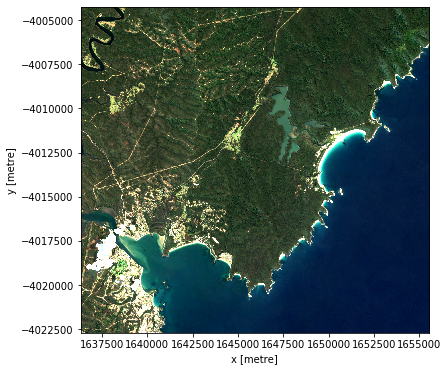

In [13]:
# visualise baseline image as  true colour image
rgb(regmedian, bands=['nbart_red', 'nbart_green', 'nbart_blue'])

### Generate Normalised Burn Ratio and visualise

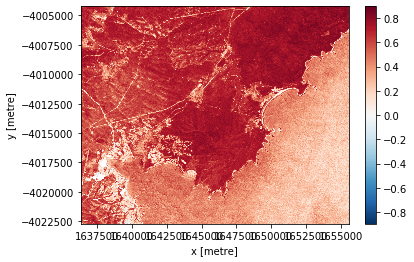

In [14]:
baseline_NBR = (regmedian.nbart_nir_1 - regmedian.nbart_swir_3)/(regmedian.nbart_nir_1 + regmedian.nbart_swir_3)
baseline_NBR.plot()

### Load post-fire data from Near Real Time data

In [15]:
# Load available data from all three Landsat satellites
Post_da = load_ard(dc=dc,
              products=['s2a_nrt_granule', 's2b_nrt_granule'],
              x=lon,
              y=lat,
              time=(end_date, change_date_end),
              min_gooddata=0.6,
              measurements=['nbart_blue','nbart_green','nbart_red','nbart_nir_1', 'nbart_swir_3'],
              output_crs='EPSG:3577',
              resolution=(-10, 10),
              group_by='solar_day')

# Print output data
Post_da = Post_da.isel(time=0)
print(Post_da)

Loading s2a_nrt_granule data
    Filtering to 1 out of 1 observations
    Applying pixel quality mask
Loading s2b_nrt_granule data
    Filtering to 0 out of 2 observations
Combining and sorting data
Masking out invalid values
    Returning 1 observations 
<xarray.Dataset>
Dimensions:       (x: 1922, y: 1848)
Coordinates:
  * y             (y) float64 -4.004e+06 -4.004e+06 ... -4.023e+06 -4.023e+06
  * x             (x) float64 1.636e+06 1.636e+06 ... 1.656e+06 1.656e+06
    time          datetime64[ns] 2020-01-10T00:06:35.251439
Data variables:
    nbart_blue    (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    nbart_green   (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    nbart_red     (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    nbart_nir_1   (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    nbart_swir_3  (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    crs:      EPSG:3577


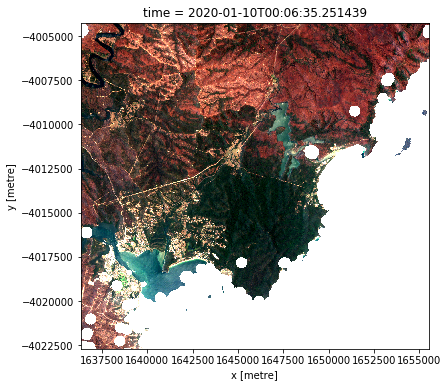

In [16]:
#Visualise post fire image as  true colour image
rgb(Post_da, bands=['nbart_red', 'nbart_green', 'nbart_blue'])

### Generate Normalised Burn Ration from post-fire data

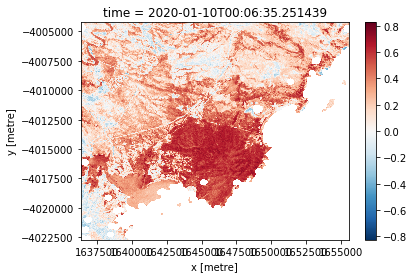

In [17]:
post_NBR = (Post_da.nbart_nir_1 - Post_da.nbart_swir_3)/(Post_da.nbart_nir_1 + Post_da.nbart_swir_3)
post_NBR = post_NBR
post_NBR.plot()

### Caculate Delta Normalised Burn Ratio

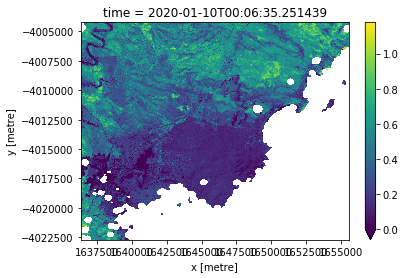

In [18]:
Delta_NBR = baseline_NBR - post_NBR

Delta_NBR.plot(cmap='viridis', vmin=0) 
# vmin sets the value to be displayed as the lowest value on the colour scale. When set to 0 only positive dNBR values 
# are visualised effectivly, any negative values are indistinquishable from 0.
#This can be adjusted to better visualise the value range presant if nessesacry

### Apply threshold to dNBR

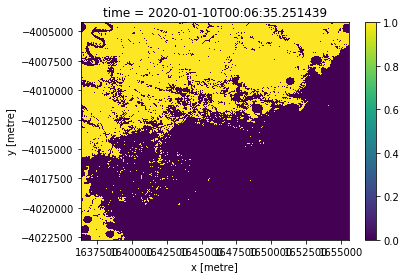

In [37]:
template = xr.full_like(Delta_NBR, 1)

Burned = template.where(Delta_NBR>0.3 ,0)

Burned.plot()

In [38]:
#turn thresholded burned area into a Xarray Dataset for export to geotiff

Burned_dataset = Burned.to_dataset(name='burn_area')

## Export results to Geotiff

To save results to geotiff for use and analysis in GIS software packages un comment the following __Write_geotiff__ comands. The baseline refference image and the post fire image will both be saved as a multiband geotiff with the following bands in the following order: Blue, Green, Red, NIR, SWIR. 

The threholded Burn Area image will be saved as a single band image, where a value of 1 = burned and a value of 0 = not burned.

In [21]:
#Define an area name to be used in saved file names

are_name = 'Example_'


In [40]:
# Write baseline refference image to multi-band GeoTIFF
write_geotiff(are_name+'Baseline_image.tif', regmedian)

# Write thresholded burn area to Single-band GeoTIFF
write_geotiff(are_name+'Burned_area.tif', Burned_dataset)

# Write post fire image to multi-band GeoTIFF
write_geotiff(are_name+'post_fire_image.tif', Post_da )